In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [4]:
# 설정: 대상 동물과 데이터 경로 설정
target_animal = 'dog'  # 'cat', 'dog' 중 선택

# 경로 설정
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'image_data', target_animal)

sys.path.append(main_path)

if not os.path.exists(data_path):
    raise ValueError(f'No such animal data path: {data_path}')

state_list = [dir_path for dir_path in os.listdir(
    data_path) if os.path.isdir(os.path.join(data_path, dir_path))]
print(f"분류할 상태 목록: {state_list}")

분류할 상태 목록: ['relax', 'hostile', 'whining']


/Users/jaewone/Downloads/FurEmotion-AI/image_data/dog/hostile/hostile_125.png


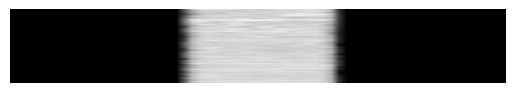

Image shape: (128, 862, 3)


In [5]:
def display_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


random_file = np.random.choice([file for file in os.listdir(
    os.path.join(data_path, state_list[1])) if file.endswith('.png')])
test_file_path = os.path.join(data_path, state_list[1], str(random_file))
print(test_file_path)

display_image(test_file_path)

# print image shape
image = Image.open(test_file_path)
image_array = np.array(image)
print(f"Image shape: {image_array.shape}")

img_height, img_width, img_channel = image_array.shape

In [ ]:
# Hyperparameters
batch_size = 32

# Load dataset
img_height, img_width = 224, 224  # Adjust based on your image dimensions

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Data performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 469 files belonging to 3 classes.
Using 423 files for training.
Found 469 files belonging to 3 classes.
Using 46 files for validation.
Class names: ['hostile', 'relax', 'whining']


In [ ]:

# Build CRNN model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, LSTM, Dense, Activation

num_classes = len(class_names)

inputs = Input(shape=(img_height, img_width, 3))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Reshape for LSTM layers
# Assuming time dimension is the width after convolutions
shape = x.get_shape().as_list()
x = Reshape((shape[1], shape[2] * shape[3]))(x)

# LSTM layers
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

# Train model
epochs = 2  # Adjust the number of epochs as needed

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Save model
model.save('crnn_pet_emotion.h5')

Epoch 1/2
14/14 [==============================] - 12s 752ms/step - loss: 0.9476 - accuracy: 0.5343 - val_loss: 1.7812 - val_accuracy: 0.1739
Epoch 2/2
14/14 [==============================] - 10s 732ms/step - loss: 0.8791 - accuracy: 0.5745 - val_loss: 2.0365 - val_accuracy: 0.1739


/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 499ms/step


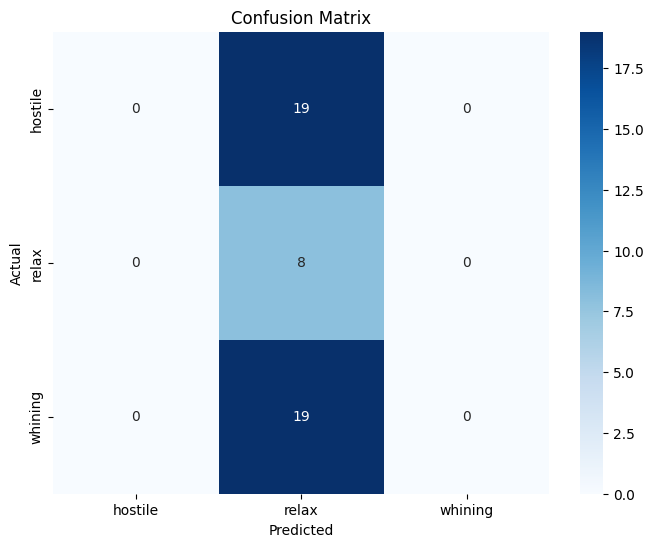

In [ ]:

# Evaluate model and compute confusion matrix
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
            yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report
              precision    recall  f1-score   support

     hostile       0.00      0.00      0.00        19
       relax       0.17      1.00      0.30         8
     whining       0.00      0.00      0.00        19

    accuracy                           0.17        46
   macro avg       0.06      0.33      0.10        46
weighted avg       0.03      0.17      0.05        46



/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

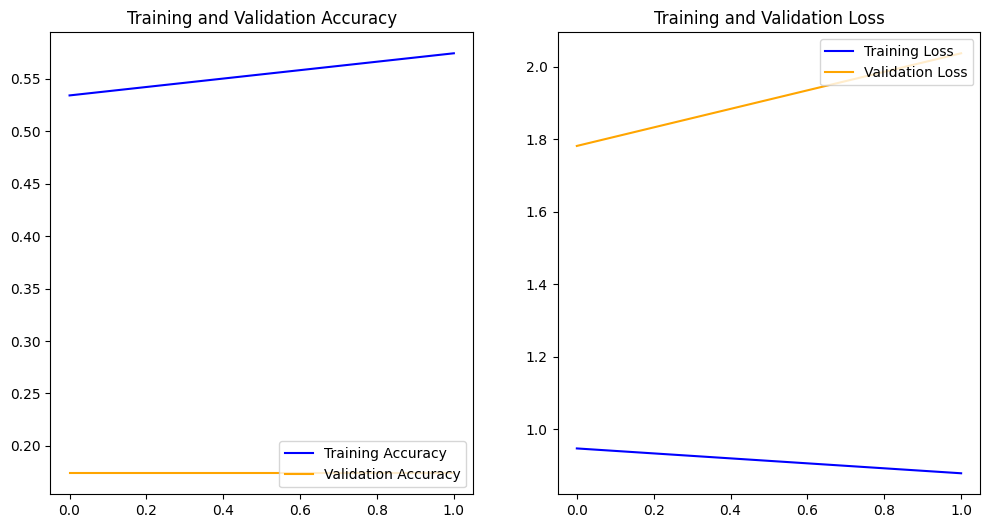

In [10]:

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()